# Import Libraries

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

2.17.1


# Import Data

In [22]:
# Read the headers
with open('/content/CommercialTransactionOffice20240913093331.csv', 'r') as f:
    headers = f.readline().strip().split(',')

# Read the data ignoring row 1 headers

data = pd.read_csv('/content/CommercialTransactionOffice20240913093331.csv', header=None, skiprows=1)
data2 = pd.read_csv('/content/CommercialTransactionRetail20240913093404.csv', header=None, skiprows=1)
data3 = pd.read_csv('/content/CommercialTransactionShop20240913093311.csv', header=None, skiprows=1)

# Combine data
data = pd.concat([data, data2, data3], axis=0)
data.columns = headers

print(headers)
print(data.head())

# count number of rows of data
print("Rows of imported data: " , len(data))

['Project Name', 'Street Name', 'Property Type', 'Transacted Price ($)', 'Area (SQFT)', 'Unit Price ($ PSF)', 'Sale Date', 'Type of Area', 'Area (SQM)', 'Unit Price ($ PSM)', 'Tenure', 'Postal District', 'Floor Level']
                Project Name       Street Name Property Type  \
0              TONG BUILDING      ORCHARD ROAD        Office   
1  ORIENTAL VENTURE BUILDING      GEYLANG ROAD        Office   
2               WOODS SQUARE  WOODLANDS SQUARE        Office   
3               WOODS SQUARE  WOODLANDS SQUARE        Office   
4                  HAVELOCK2     HAVELOCK ROAD        Office   

  Transacted Price ($) Area (SQFT) Unit Price ($ PSF) Sale Date Type of Area  \
0           31,330,000    6,867.43              4,562    Sep-24       Strata   
1            1,480,000    1,097.93              1,348    Aug-24       Strata   
2            1,975,490      947.23              2,086    Aug-24       Strata   
3            1,163,581      559.73              2,079    Aug-24       Strata

# Clean Data

In [23]:
# Delete Empty rows
data.dropna(how='all', inplace=True)

# convert string to float
data['Transacted Price ($)'] = data['Transacted Price ($)'].str.replace(',', '')
data['Transacted Price ($)'] = data['Transacted Price ($)'].astype(float)

data['Area (SQFT)'] = data['Area (SQFT)'].str.replace(',', '')
data['Area (SQFT)'] = data['Area (SQFT)'].astype(float)

data['Unit Price ($ PSF)'] = data['Unit Price ($ PSF)'].str.replace(',', '')
data['Unit Price ($ PSF)'] = data['Unit Price ($ PSF)'].astype(float)

data['Area (SQM)'] = data['Area (SQM)'].str.replace(',', '')
data['Area (SQM)'] = data['Area (SQM)'].astype(float)

data['Unit Price ($ PSM)'] = data['Unit Price ($ PSM)'].str.replace(',', '')
data['Unit Price ($ PSM)'] = data['Unit Price ($ PSM)'].astype(float)

# Print datatype
print(data.dtypes)

Project Name             object
Street Name              object
Property Type            object
Transacted Price ($)    float64
Area (SQFT)             float64
Unit Price ($ PSF)      float64
Sale Date                object
Type of Area             object
Area (SQM)              float64
Unit Price ($ PSM)      float64
Tenure                   object
Postal District           int64
Floor Level              object
dtype: object


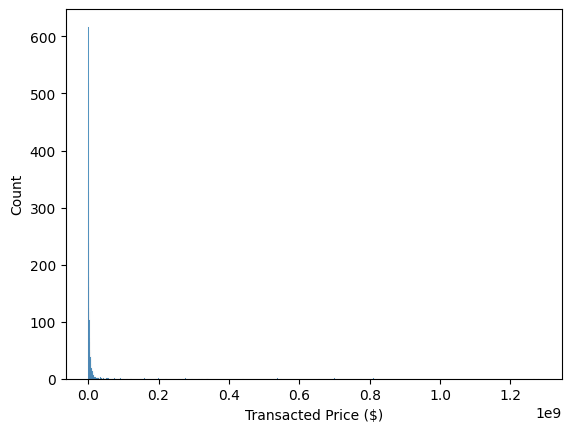

In [24]:
# print distribution of transacteed price
sns.histplot(data['Transacted Price ($)'])
plt.show()

# Prepare Data and Split into Train and Test



In [32]:
# prompt: Create linear regression model for predicting transacted price without the unit price columns and for categorical data, use one hot encoding

# Select relevant features
features = ['Area (SQFT)', 'Area (SQM)', 'Property Type', 'Street Name', 'Tenure', 'Type of Area', 'Postal District', "Floor Level"]
X = data[features]
y = data['Transacted Price ($)']

# test some modification !!!
# Example of log transforming Area and Price
X['Area (SQM)'] = np.log1p(X['Area (SQM)'])
X['Area (SQFT)'] = np.log1p(X['Area (SQFT)'])
y = np.log1p(y)  # if your target (price) is also skewed

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# One-Hot Encoding Example (for small number of categories)
X_encoded = pd.get_dummies(X, columns=['Property Type', 'Street Name', 'Tenure', 'Type of Area', 'Postal District', "Floor Level"])

from sklearn.model_selection import train_test_split

# Assuming 'y' is your target variable (e.g., price)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# export my X_encoded headers to .dat
headers = X_encoded.columns
np.savetxt('headers.dat', headers, fmt='%s')

<ipython-input-32-013379aab847>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Area (SQM)'] = np.log1p(X['Area (SQM)'])
<ipython-input-32-013379aab847>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Area (SQFT)'] = np.log1p(X['Area (SQFT)'])


# Define XGBoost Model

Mean Squared Error: 0.11477762091704319
R-squared: 0.9242185434546155


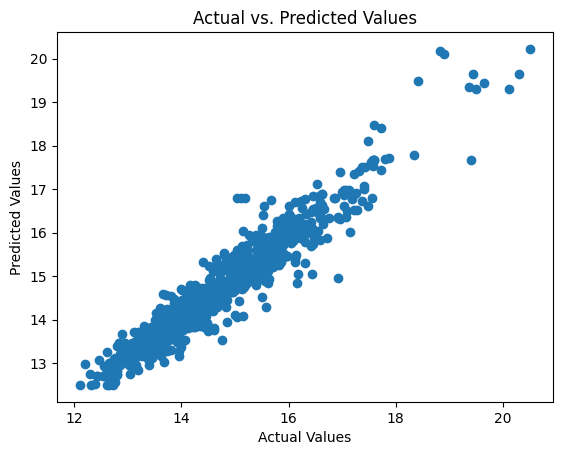

In [ ]:
import xgboost as xgb

# Convert data to DMatrix (optional but recommended for efficiency)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use appropriate objective for regression
    max_depth=6,  # Depth of each tree
    learning_rate=0.1,  # Step size shrinkage
    n_estimators=100  # Number of boosting rounds
)

# Train the model
model.fit(X_train, y_train)


from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

In [12]:
# test_data = ['CONCORDE SHOPPING CENTRE','OUTRAM ROAD','Office','688000', '376.74', '1.826', 'Dec-24','Strata', '35.0', '19657', '99 yrs lease commencing from 1980', '03', '01 to 05']
test_data = ['THOMSON V TWO','SIN MING ROAD','Retail','300000.0', '53.82','5.574', 'Jul-21','Strata','5.0', '60000.0', 'Freehold', '20', '01 to 05']
# test_data = ['REGENCY SUITES','KIM TIAN ROAD','Office','2120000','1033.34','2.052','Nov-24','Strata','96','22083','Freehold','03','06 to 10']

# Select relevant features
features = ['Area (SQFT)', 'Area (SQM)', 'Property Type', 'Street Name', 'Tenure', 'Type of Area', 'Postal District', "Floor Level"]
headers = ['Project Name', 'Street Name', 'Property Type', 'Transacted Price ($)', 'Area (SQFT)', 'Unit Price ($ PSF)', 'Sale Date', 'Type of Area', 'Area (SQM)', 'Unit Price ($ PSM)', 'Tenure', 'Postal District', 'Floor Level']

# insert data into df with headers
test_data = pd.DataFrame([test_data], columns=headers)

# Consolidate cleaning steps for columns with potential commas
for col in ['Transacted Price ($)', 'Area (SQFT)', 'Unit Price ($ PSF)', 'Area (SQM)', 'Unit Price ($ PSM)']:
    test_data[col] = test_data[col].str.replace(',', '').astype(float)


# Print datatype
print(test_data.dtypes)

# set x and y
X_test_data = test_data[features]
y_test_data = test_data['Transacted Price ($)']

# transform data
X_test_data.loc[:, 'Area (SQM)'] = np.log1p(X_test_data['Area (SQM)'])
X_test_data.loc[:, 'Area (SQFT)'] = np.log1p(X_test_data['Area (SQFT)'])

# One-Hot Encoding Example (for small number of categories)
X_test_data_encoded = pd.get_dummies(X_test_data, columns=['Property Type', 'Street Name', 'Tenure', 'Type of Area', 'Postal District', "Floor Level"])

#read One-hot encoded headers
with open('/content/headers.dat', 'r') as f:
    test_headers = f.read().splitlines()

# Align columns of X_test_data_encoded with One-hot encoded headers
X_test_data_encoded = X_test_data_encoded.reindex(columns = test_headers, fill_value=0)

# Load Model
model = xgb.Booster()
model.load_model('0001.model')
test_data_dmatrix = xgb.DMatrix(X_test_data_encoded)
predicted_price = model.predict(test_data_dmatrix)

# revert np.log1p
predicted_price = np.expm1(predicted_price)
print("Predicted: ", predicted_price[0])
print("Actual: ", y_test_data[0])

Project Name             object
Street Name              object
Property Type            object
Transacted Price ($)    float64
Area (SQFT)             float64
Unit Price ($ PSF)      float64
Sale Date                object
Type of Area             object
Area (SQM)              float64
Unit Price ($ PSM)      float64
Tenure                   object
Postal District          object
Floor Level              object
dtype: object
Predicted:  277854.06
Actual:  300000.0


In [9]:
# Save the model
# model.save_model('0001.model')

# Load the model
model = xgb.Booster()
model.load_model('0001.model')

# Predict on test data
y_pred = model.predict(test_data_dmatrix)

# revert y_pred
y_pred = np.expm1(y_pred)

#print original and pred
print("Predicted: ", y_pred[0])
print("Actual: ", y_test_data[0])
print("Difference: ", abs(y_pred[0] - y_test_data[0]))

Predicted:  2031106.4
Actual:  2120000.0
Difference:  88893.625
